# Speaker recognition 

Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import sklearn.model_selection as sk
import glob
import os
import sounddevice as sd
import librosa
import librosa.display
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.regularizers import l2
import pickle

Using TensorFlow backend.


Parameters

In [2]:
fs = 44100
no_mfcc=20
max_len=300

Custom dataset

Load files. Extract features

In [32]:
x=[]

y1=[]

for file in glob.glob("C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Datasets\\Custom\\All\\*"):
    basename=os.path.basename(file)
    person=basename.split("_")[1]
    y1.append(int(person))
    file_temp,fs_temp=librosa.load(file, sr=fs)
    mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
    if (max_len > mfcc_features.shape[1]):
        pad_width = max_len - mfcc_features.shape[1]
        mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc_features = mfcc_features[:, :max_len]
    x.append(mfcc_features)
    
with open('Saved Persons','wb') as f:
    pickle.dump(y1,f)


RAVDESS Dataset

Load files. Extract features

In [3]:
x=[]
y =[]

y1=[]

for file in glob.glob("C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Datasets\\Ravdess\\All\\*"):
    basename=os.path.basename(file)
    emotion=basename.split("-")[2]
    person=basename.split("-")[6]
    person=person.split(".")[0]
    phrase=basename.split("-")[4]
    repetition=basename.split("-")[5]
    y1.append(int(person)-1)
    file_temp,fs_temp=librosa.load(file, sr=fs)
    #mfcc_features=librosa.feature.melspectrogram(file_temp,sr=fs,  n_mels=128, fmax=8000)
    mfcc_features=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=20)
    if (max_len > mfcc_features.shape[1]):
        pad_width = max_len - mfcc_features.shape[1]
        mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc_features = mfcc_features[:, :max_len]
    x.append(mfcc_features)


In [40]:
x=np.array(x)
y1=np.array(y1)
x.shape

(1435, 20, 300, 1)

In [41]:
#Note that mfcc operation returns (n_mfcc, time). 
#You have to do an axis permutation to get it to (time, n_mfcc) format. 
#So that the convolution happens on the time dimension.

In [42]:
##Normalize!!

Model

Model parameters

In [43]:
no_classes=max(y1)+1
no_channels=1

x_reshape=(x.shape[0],20,x.shape[2],no_channels)
input_shape=(20,x.shape[2],no_channels)

Create model

In [44]:
x = x.reshape(x_reshape)

x_train, x_test, y1_train, y1_test = sk.train_test_split(x,y1,test_size=0.2)
y1_train = tf.keras.utils.to_categorical(y1_train,num_classes=no_classes)
y1_test = tf.keras.utils.to_categorical(y1_test,num_classes=no_classes)

In [45]:
x_train.shape

(1148, 20, 300, 1)

In [46]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(2, 2), kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))



model.add(layers.Conv2D(48, kernel_size=(2, 2),kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))




model.add(layers.Flatten())

model.add(layers.Dense(no_classes, activation='softmax'))


In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 19, 299, 8)        40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 149, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 148, 16)        528       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 74, 16)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 73, 32)         2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 36, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

Compile model

In [48]:

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


Train model

In [49]:
history = model.fit(x_train, y1_train, epochs=45,verbose=1, validation_data=(x_test,y1_test))

Train on 1148 samples, validate on 287 samples
Epoch 1/45
1148/1148 [==============================] - 2s 2ms/sample - loss: 10.0219 - accuracy: 0.0566 - val_loss: 3.2145 - val_accuracy: 0.0801
Epoch 2/45
1148/1148 [==============================] - 1s 765us/sample - loss: 2.7460 - accuracy: 0.2073 - val_loss: 2.3897 - val_accuracy: 0.2857
Epoch 3/45
1148/1148 [==============================] - ETA: 0s - loss: 1.9209 - accuracy: 0.43 - 1s 822us/sample - loss: 1.9177 - accuracy: 0.4321 - val_loss: 1.8430 - val_accuracy: 0.4355
Epoch 4/45
1148/1148 [==============================] - 1s 816us/sample - loss: 1.2539 - accuracy: 0.6185 - val_loss: 1.3237 - val_accuracy: 0.6098
Epoch 5/45
1148/1148 [==============================] - 1s 787us/sample - loss: 0.7865 - accuracy: 0.7909 - val_loss: 1.1268 - val_accuracy: 0.6132
Epoch 6/45
1148/1148 [==============================] - 1s 808us/sample - loss: 0.4738 - accuracy: 0.8746 - val_loss: 0.9733 - val_accuracy: 0.7108
Epoch 7/45
1148/1148 [==

## Evaluate model

In [53]:
test_loss, test_acc = model.evaluate(x_test,  y1_test, verbose=2)

print('\nTest accuracy:', test_acc)

287/287 - 0s - loss: 0.7925 - accuracy: 0.8328

Test accuracy: 0.8327526


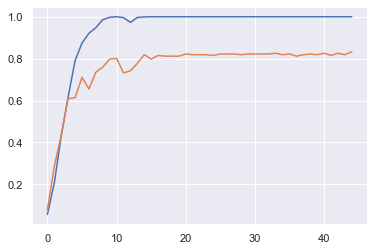

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

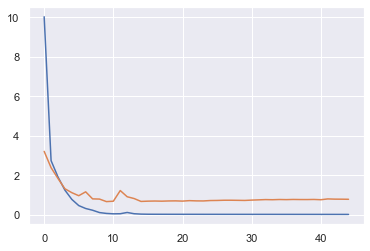

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [56]:
file="C:\\Users\\tmacovei001\\Desktop\\Speaker Recognition\\Code\\voice_01_1_neutral.wav"

In [57]:
file_temp,fs_temp=librosa.load(file, sr=fs)
mfcc_test=librosa.feature.mfcc(file_temp,sr=fs, S=None, n_mfcc=no_mfcc)
if (max_len > mfcc_test.shape[1]):
    pad_width = max_len - mfcc_test.shape[1]
    mfcc_test = np.pad(mfcc_test, pad_width=((0, 0), (0, pad_width)), mode='constant')
else:
    mfcc_test = mfcc_test[:, :max_len]

mfcc_test=mfcc_test.reshape((1,20,x.shape[2],no_channels))

In [58]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(mfcc_test)
predictions[0]

array([0.0392428 , 0.03924167, 0.03927461, 0.03924167, 0.03926451,
       0.03924167, 0.03924168, 0.03924168, 0.04004551, 0.03927935,
       0.03924167, 0.03924167, 0.03924173, 0.03924167, 0.03927412,
       0.03924167, 0.09064803, 0.03924167, 0.03924169, 0.03924167,
       0.04510429, 0.03924167, 0.03924172, 0.03924167], dtype=float32)

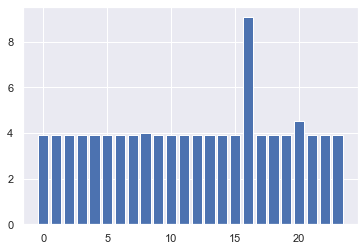

In [59]:
i = 0
thisplot = plt.bar(range(24), 100*predictions[0])


plt.show()

In [46]:
model.save('person_model')

INFO:tensorflow:Assets written to: person_model\assets


In [47]:
model2 = tf.keras.models.load_model('person_model')

In [16]:
predictions[0]

NameError: name 'predictions' is not defined

In [30]:
from sklearn.metrics import confusion_matrix

In [60]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

In [61]:
y_pred = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(y1_test, axis=1)
rounded_labels[1]

cnf_matrix = confusion_matrix(rounded_labels, y_pred)
cnf_matrix

array([[ 9,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  2,  0,  0,  0,  1],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 11,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  9,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 

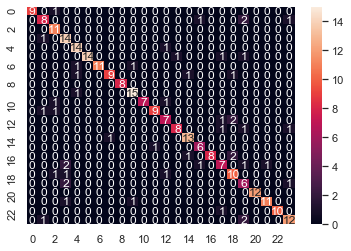

In [62]:
sns.heatmap(cnf_matrix,annot=True)